In [1]:
import datacube
from datacube.index.hl import Doc2Dataset
from eodatasets3 import serialise

import pandas as pd
import numpy as np

import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import odc.geo.xr

from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize

import geopandas as gpd
from odc.geo.geom import BoundingBox

import pystac_client
import odc.stac
from odc.stac import configure_rio
from datacube.utils.aws import configure_s3_access
import planetary_computer
from pystac_client.stac_api_io import StacApiIO
from urllib3 import Retry

from distributed import LocalCluster, Client

import os
import gc
import sys
import json
import datetime
import pytz
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# Path to "src"
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from utils.downsample import s2_downsample_dataset_10m_to_20m
from utils.metadata import prepare_eo3_metadata_NAS
from utils.sentinel2 import check_gri_refinement, mask_with_scl, plot_mgrs_tiles_with_aoi
from utils.utils import mkdir, get_sys_argv, setup_logger
from utils.timeseries_processing import process_epsg, merge_nodata0, save_dataset_preview

### Setup input parameters

In [2]:
parameters_dict = {
    "AOI_path": '../anciliary/grid_v2.geojson',
    "year_month": "2024-07"
}

In [3]:
year_month = parameters_dict['year_month']
AOI_path = parameters_dict['AOI_path'] #'../anciliary/grid_v2.geojson'
                
aoi = gpd.read_file(AOI_path).to_crs('EPSG:4326')

In [4]:
year_month = year_month
tile = aoi.iloc[18]

### Start processing

In [5]:
log = setup_logger(
    logger_name='compgen_',
    logger_path=f'../logs/debug_compgen_{datetime.datetime.now(pytz.timezone("Europe/Athens")).strftime("%Y%m%dT%H%M%S")}.log', 
    logger_format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s',
    )

In [6]:
tile_id = tile.tile_ids
log.info('#######################################################################')
log.info('Processing started')
log.info(f'        Tile: {tile_id}')
log.info(f'        Time: {year_month}')


log.info('                          ')
log.info('Establishing connection to datacube')
dc = datacube.Datacube(app='Composite generation', env='drought')

log.info('                          ')
log.info('Check if dataset already exists in the datacube')
find_ds_in_sc = dc.find_datasets(
    **dict(
        product='composites',
        time=year_month,
        region_code=tile_id
    ),
    ensure_location=True
)
    
if find_ds_in_sc:
    msg = f"This composite already exists in {find_ds_in_sc[0].uri} | Continuing."
    log.warning(msg)
    # return
else:
    log.info("The composite requested will be computed")


log.info('Create directories and naming conversions')
yyyy = year_month[0:4]
mm1 = year_month[5:8]
NASROOT='//nas-rs.topo.auth.gr/Latomeia/DROUGHT'
FOLDER=f'COMPOS/{yyyy}/{mm1}/{tile_id}'
DATASET= f'S2L2A_medcomp_{tile_id}_{yyyy}{mm1}'
PRODUCT_NAME = 'composites'
collection_path = f"{NASROOT}/{FOLDER}"
mkdir(collection_path)
eo3_path = f'{collection_path}/{DATASET}.odc-metadata.yaml'
stac_path = f'{collection_path}/{DATASET}.stac-metadata.json'
log.info(f'Dataset location: {collection_path}')


log.info('                          ')
log.info('Retrieve tile geometry')
geom = gpd.GeoSeries([tile.geometry], crs='EPSG:4326').to_crs(epsg=3035)
minl, minf, maxl, maxf = tile.geometry.bounds
minx, miny, maxx, maxy = geom.total_bounds

log.info('Create the Bounding Box (φ,λ)')
aoi_bbox = BoundingBox.from_xy(
    (minl, maxl),
    (minf, maxf)
).buffered(xbuff=0.025, ybuff=0.025)

log.info('Create the Bounding Box (y,x)')
tile_bbox = BoundingBox.from_xy(
    (minx, maxx),
    (miny, maxy),
    crs='EPSG:3035'
)

tile_geobox = odc.geo.geobox.GeoBox.from_bbox(
    tile_bbox, 
    resolution=odc.geo.Resolution(x=20,y=-20)
)


In [7]:
aoi_bbox.explore()

In [8]:
log.info('                          ')
log.info('Connect to Planetary Computer STAC Catalog')
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

log.info('Search the STAC Catalog')
cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-07',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)
log.info('        Query parameters:')
log.info(f'            url:          {search.url}')
log.info(f'            client:       {search.client.id}')
log.info(f'            collection:   {search._parameters['collections'][0]}')
log.info(f'            bbox:         {search._parameters['bbox']}')
log.info(f'            time range:   {search._parameters['datetime']}')
log.info(f'            cloud cover:  0% - {search._parameters['query']['eo:cloud_cover']['lt']}%')
log.info(f'            nodata cover: 0% - {search._parameters['query']['s2:nodata_pixel_percentage']['lt']}%')


In [9]:
log.info('                          ')
log.info('Searching...')
items = search.item_collection()

log.info(f'Query found {len(items)} items')

In [10]:
log.info('Searching for GRI REFINED scenes:')
refined_items, df_refinement_status = check_gri_refinement(items)

log.info('                                 ')
log.info(f'{len(refined_items)}/{len(df_refinement_status)} were refined by GRI.')

In [11]:
if len(refined_items) == 0:
    msg = f"Tile {tile_id} | Time: {year_month}: All scenes are flagged NOT REFINED."
    log.warning(msg)
    log.warning(f"Tile {tile_id} | Time: {year_month}: The composite will be flagged with _NOREFINED.")
    REFINEMENT_FLAG = 'NOTREFINED'
    refined_items = items
else:
    REFINEMENT_FLAG = 'REFINED'

In [12]:
N = 10
log.info(f'Looking for up to {N} cleanest images within spatiotemporal range')
filtered_items = []
mgrs_tiles = np.unique([i.properties['s2:mgrs_tile'] for i in refined_items])
epsgs = np.unique([i.properties['proj:epsg'] for i in refined_items])

for mgrstile in mgrs_tiles:
    item_mgrs_sorted = sorted([
        i for i in refined_items if i.properties['s2:mgrs_tile'] == str(mgrstile)
        ], key=lambda item: item.properties['eo:cloud_cover'])
    
    if len(item_mgrs_sorted) > N:
        filtered_items.extend(item_mgrs_sorted[:N])
    else:
        filtered_items.extend(item_mgrs_sorted)
log.info(f"Filtered cleanest scenes: Kept {len(filtered_items)} out of {len(refined_items)} items. ")
log.info(f"        Included MGRS Tiles: {mgrs_tiles}")
log.info(f"        Included EPSG codes: {epsgs}")

log.info('Selected scenes:')
for stacitem in filtered_items:
    log.info(f'        {stacitem.id}')


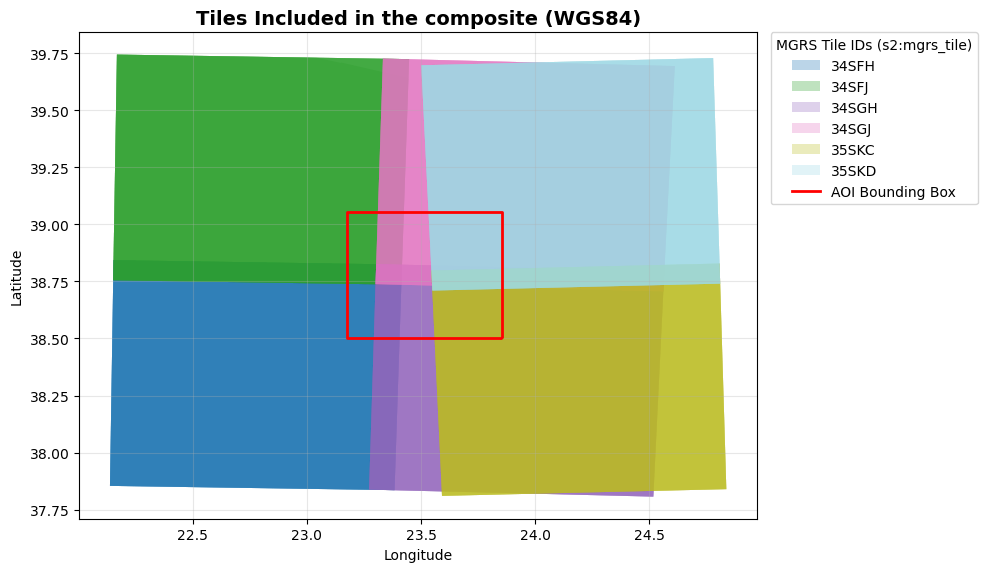

In [13]:
plot_mgrs_tiles_with_aoi(filtered_items, aoi_bbox)

In [14]:
plot_mgrs_tiles_with_aoi(filtered_items, 
                            aoi_bbox, 
                            save_path=f'{collection_path}/{DATASET}_InDataFootprint.jpeg')
    

In [ ]:
log.info('                                 ')
log.info('Initializing Dask cluster for parallelization')
cluster = LocalCluster(
    n_workers=8, 
    threads_per_worker=1, 
    processes=False,
    memory_limit='5GB', 
    # local_directory="/tmp/dask-worker-space",
    )
client = Client(cluster)
configure_rio(cloud_defaults=True, client=client) # For Planetary Computer
log.info(f'The Dask client listens to {client.dashboard_link}')

2025-08-15 19:27:16,431 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.11 GiB -- Worker memory limit: 4.66 GiB
2025-08-15 19:27:39,100 - distributed.worker.memory - WARNING - Worker is at 99% memory usage. Pausing worker.  Process memory: 4.64 GiB -- Worker memory limit: 4.66 GiB
2025-08-15 19:27:39,235 - distributed.worker.memory - WARNING - Worker is at 100% memory usage. Pausing worker.  Process memory: 4.67 GiB -- Worker memory limit: 4.66 GiB
2025-08-15 19:27:39,369 - distributed.worker.memory - WARNING - Worker is at 100% memory usage. Pausing worker.  Process memory: 4.69 GiB -- Worker memory limit: 4.66 GiB
2025-08-15 19:27:39,507 - distributed.worker.memory - WARNING - Worker is at 101% memory usage. Pausing worker.  Process memory: 4.75 G

In [16]:
log.info(f'                                 ')
log.info(f'Downstream STAC items from Planetary Computer')

In [17]:
processed_epsgs = []
for EPSG in epsgs:
    processed_epsgs.append(process_epsg(filtered_items, aoi_bbox, EPSG))

2025-08-15 19:28:33,122 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling ['finalize-hlgfinalizecompute-9817963db4044984b8a5b8936fb536d8']


In [18]:
log.info('Clip and align to tile geometry')
processed_epsgs_to_tile = [ds.odc.reproject(how=tile_geobox) for ds in processed_epsgs]

In [19]:
if len(processed_epsgs)>1:
    log.info(f'                          ')
    log.info(f'Mosaic datasets of different native UTM zones to a single dataset')
    ds_timeseries = merge_nodata0(processed_epsgs_to_tile, vars_mode="intersection", method="mean", chunks=None)
else:
    ds_timeseries = processed_epsgs[0]

In [20]:
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Baseline-Change
baseline400_mask = ds_timeseries.time > pd.Timestamp('2022-01-25')
if baseline400_mask.any():
    log.info('Scale SR to Sen2Cor Baseline 4.00 - Subtract 1000 in dates post 2022-01-25')
    ds_timeseries = ds_timeseries.where(~baseline400_mask, ds_timeseries - 1000)
else:
    del baseline400_mask

In [21]:
# reset bands list
BANDS = ['B02', 'B03', 'B04', 'B05', 'B07', 'B8A']
ds_timeseries = ds_timeseries[['B02', 'B03', 'B04', 'B05', 'B07', 'B8A']]

In [22]:
log.info('////Clearing up space////')
del processed_epsgs_to_tile
gc.collect()

56

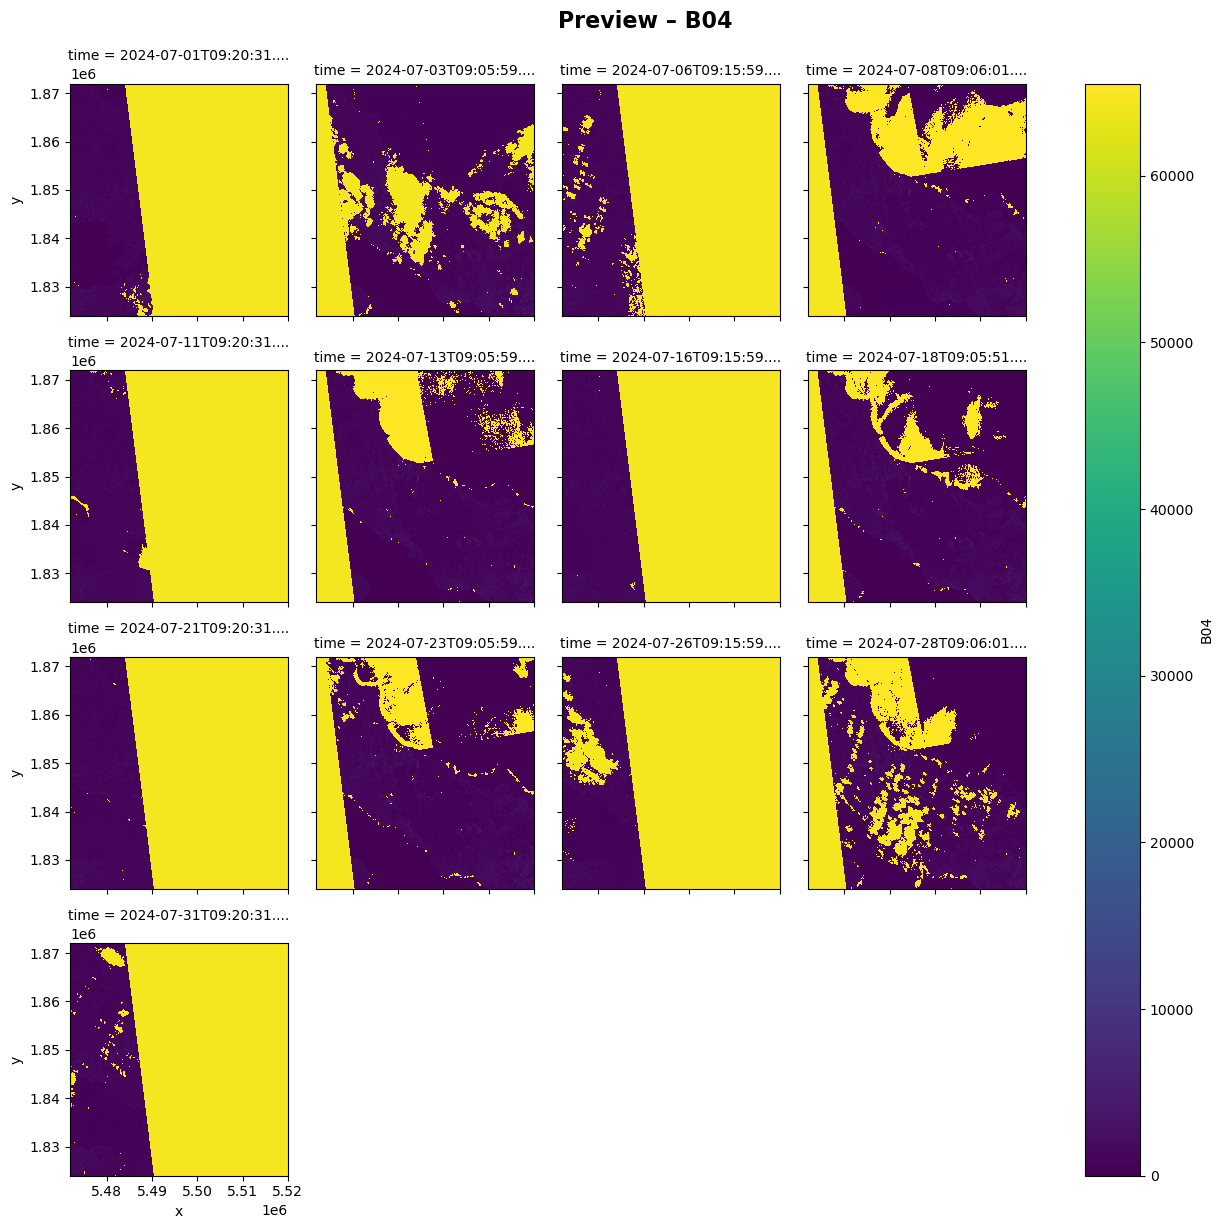

In [23]:
log.info('Creating preview plot of input scenes')
save_dataset_preview(ds_timeseries, "B04", f'{collection_path}/{DATASET}_InDataPreview.jpeg', dpi=300)

In [24]:
log.info('Clip value range')
# chunks = {"time": 1, "y": 1024, "x": 1024}
# ds_timeseries = ds_timeseries.chunk(chunks)
ds_timeseries = ds_timeseries.where(ds_timeseries > 0, np.nan)
ds_timeseries = ds_timeseries.where(ds_timeseries<=10000)

In [25]:
log.info(f'                          ')
log.info('Computing spectral indices:')
SIS = ['evi', 'ndvi', 'psri2']

log.info('    EVI...')
ds_timeseries['evi'] = 2.5 * ((ds_timeseries.B8A - ds_timeseries.B04)/10000) / ((ds_timeseries.B8A/10000 + 6*ds_timeseries.B04/10000 - 7.5*ds_timeseries.B02/10000) + 1)
log.info('    NDVI...')
ds_timeseries['ndvi'] = ((ds_timeseries.B05 - ds_timeseries.B03) / ds_timeseries.B07).astype('float32')
log.info('    PSRI2...')
ds_timeseries['psri2'] = ((ds_timeseries.B8A - ds_timeseries.B04) / (ds_timeseries.B8A + ds_timeseries.B04)).astype('float32')

log.info('Clip to typical value range')
for si in SIS:
    if si in ['ndvi', 'evi']:
        ds_timeseries[si] = ds_timeseries[si].where((ds_timeseries[si]>=-1)&(ds_timeseries[si]<=1))
    else:
        ds_timeseries[si] = ds_timeseries[si].where((ds_timeseries[si]>=-1)&(ds_timeseries[si]<=4))


In [26]:
log.info('Reducing to median value temporal composite')
# ds_timeseries = ds_timeseries.chunk(chunks)
ds_timeseries = ds_timeseries.sortby('time')
composite = ds_timeseries.median(dim='time').astype('float32').compute()

In [27]:
log.info('Define data types and nodata per band')
VARS = BANDS+SIS

for band in BANDS:
    dtype = 'uint16'
    nodata = np.iinfo(np.uint16).min #0
    composite[band] = composite[band].astype(dtype)
    composite[band] = composite[band].rio.write_nodata(nodata, inplace=True)
    composite[band].encoding.update({"dtype": dtype})
    
for si in SIS:  
    scale = 1000 
    dtype = 'int16'
    nodata = np.iinfo(np.int16).min #-32768
    composite[si] = (composite[si]*scale).round()
    composite[si] = composite[si].fillna(nodata).astype(dtype)
    composite[si] = composite[si].rio.write_nodata(nodata, inplace=True)
    composite[si].encoding.update({"dtype": dtype})
    # composite[si].encoding["scale_factor"] = 1/scale

In [28]:
log.info('Assign time range and tile ID in metadata')
yyyy = ds_timeseries.isel(time=0).time.dt.year.item()
mm1 = ds_timeseries.isel(time=0).time.dt.month.item()
mm2 = ds_timeseries.isel(time=-1).time.dt.month.item()
dd1 = ds_timeseries.isel(time=0).time.dt.day.item()
dd2 = ds_timeseries.isel(time=-1).time.dt.day.item()
composite.attrs['dtr:start_datetime']=f'{yyyy}-{mm1:02d}-{dd1:02d}'
composite.attrs['dtr:end_datetime']=f'{yyyy}-{mm2:02d}-{dd2:02d}'
composite.attrs['odc:region_code']=tile_id
composite.attrs['gri:refinement']=REFINEMENT_FLAG

In [29]:
log.info('Write bands to raster COG files')
name_measurements = []
for var in list(composite.data_vars):
    file_path = f'{collection_path}/{DATASET}_{var}.tif'
    
    composite[var].rio.to_raster(
        raster_path=file_path, 
        driver='COG',
        dtype=str(composite[var].dtype),
        windowed=True
        )
    name_measurements.append(file_path)
    
    log.info(f'Write {var.upper()} -> {file_path}')

In [30]:
datetime_list = [
    ds_timeseries.isel(time=0).time.dt.year.item(),
    ds_timeseries.isel(time=0).time.dt.month.item(),
    1
]

In [31]:
eo3_doc, stac_doc = prepare_eo3_metadata_NAS(
    dc=dc,
    xr_cube=composite, 
    collection_path=collection_path,
    dataset_name=DATASET,
    product_name=PRODUCT_NAME,
    product_family='ard',
    bands=VARS,
    name_measurements=name_measurements,
    datetime_list=datetime_list,
    set_range=False,
    lineage_path=None,
    version=1,
    )

In [32]:
log.info('Write metadata YAML document to disk')
serialise.to_path(Path(eo3_path), eo3_doc)
with open(stac_path, 'w') as json_file:
    json.dump(stac_doc, json_file, indent=4, default=False)

In [37]:
log.info('Create datacube.model.Dataset from eo3 metadata')
WORKING_ON_CLOUD=False
uri = eo3_path if WORKING_ON_CLOUD else f"file:///{eo3_path}"

resolver = Doc2Dataset(dc.index)
dataset_tobe_indexed, err  = resolver(doc_in=serialise.to_doc(eo3_doc), uri=uri)


In [39]:
if err:
    log.error(err)

In [40]:
log.info('Index to datacube')
dc.index.datasets.add(dataset=dataset_tobe_indexed, with_lineage=False)

Dataset <id=1ce28150-59bf-4eba-a574-f1093989fe84 product=composites location=file://///nas-rs.topo.auth.gr/Latomeia/DROUGHT/COMPOS/2024/07/x11_y12/S2L2A_medcomp_x11_y12_202407.odc-metadata.yaml>

# Test loading

In [42]:
new_ds = dc.load(
    product=PRODUCT_NAME,
    region_code=tile_id,
    time=year_month
)

In [43]:
new_ds

<xarray.Dataset> Size: 104MB
Dimensions:      (time: 1, y: 2401, x: 2401)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-07-01
  * y            (y) float64 19kB 1.872e+06 1.872e+06 ... 1.824e+06 1.824e+06
  * x            (x) float64 19kB 5.472e+06 5.472e+06 ... 5.52e+06 5.52e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (time, y, x) uint16 12MB 1531 1848 1857 1522 ... 1987 1875 1717
    B03          (time, y, x) uint16 12MB 1880 2235 2270 1884 ... 2456 2333 2143
    B04          (time, y, x) uint16 12MB 1959 2497 2553 2023 ... 3059 2900 2664
    B05          (time, y, x) uint16 12MB 2553 3213 3306 2651 ... 3606 3459 3061
    B07          (time, y, x) uint16 12MB 3755 4179 4334 3955 ... 4285 4187 4100
    B8A          (time, y, x) uint16 12MB 4060 4486 4661 4347 ... 4701 4566 4488
    ndvi         (time, y, x) int16 12MB 367 316 319 394 472 ... 236 219 233 257
    evi          (time, y, x) int16 12MB 177 228 236 183 157 ... 256 275 262 235
    psri2        (time, y, x) int16 12MB 349 282 285 365 441 ... 221 203 223 253
Attributes:
    crs:           EPSG:3035
    grid_mapping:  spatial_ref

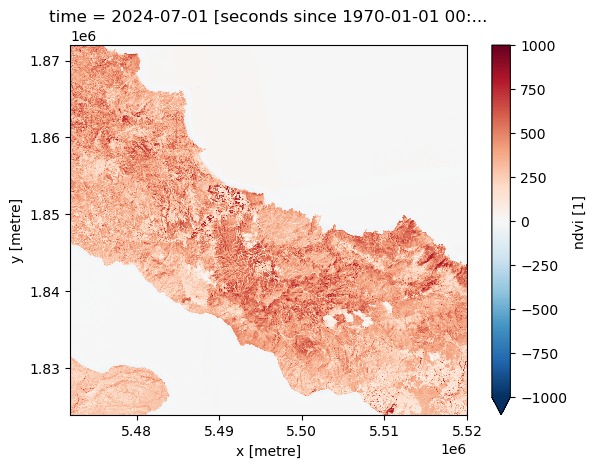

In [45]:
new_ds.ndvi.plot(vmin=-1000)

In [46]:
new_ds.ndvi.max()

<xarray.DataArray 'ndvi' ()> Size: 2B
array(999, dtype=int16)
Coordinates:
    spatial_ref  int32 4B 3035

In [53]:
new_ds.ndvi.where(new_ds.ndvi!=new_ds.ndvi.nodata).min()

<xarray.DataArray 'ndvi' ()> Size: 4B
array(-629., dtype=float32)
Coordinates:
    spatial_ref  int32 4B 3035